In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/SOLO')
sys.path.append(str(base))

Mounted at /content/drive


In [2]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/SOLO")
os.listdir()

['config.py',
 'mmdetection',
 'colab_installed.txt',
 'pretrained',
 '__pycache__',
 'loss.py',
 'dataset.py',
 'SOLO.ipynb',
 'models.py',
 'utils.py',
 'Test.ipynb']

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

from PIL import Image

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data

import tqdm
from torchsummary import summary
import seaborn as sns

In [4]:
from models import Autoencoder
from models import AutoencoderLN
from models import FixedAutoencoder
from loss import Loss
from loss import DiceLoss
from loss import FocalLoss
from dataset import CocoDataset
from utils import *

In [5]:
#!wget http://images.cocodataset.org/zips/train2017.zip
#!wget http://images.cocodataset.org/zips/val2017.zip
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [6]:
#!unzip 'train2017.zip'
#!unzip 'val2017.zip'
#!unzip 'annotations_trainval2017.zip'

#!rm 'train2017.zip'
#!rm 'val2017.zip'
#!rm 'annotations_trainval2017.zip'

##Prepare data

In [7]:
transform = transforms.Compose(
      [transforms.ToPILImage(),
       transforms.Scale(256),
       transforms.CenterCrop(224),
       transforms.ToTensor()]
       #transforms.Normalize(mean=[0.5],
                                  #std=[0.5])]
  )

val_loader = get_loader(root='mmdetection/val2017', 
                        json='mmdetection/annotations/instances_val2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


loading annotations into memory...
Done (t=2.70s)
creating index...
index created!


In [8]:
train_loader = get_loader(root='mmdetection/train2017', 
                        json='mmdetection/annotations/instances_train2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)

loading annotations into memory...
Done (t=22.96s)
creating index...
index created!


##Try Neptune

Результаты [тут](https://ui.neptune.ai/a.chubcheva/Instance-segmentation/experiments?viewId=standard-view)

In [9]:
!pip install neptune-client

     |████████████████████████████████| 112kB 4.2MB/s 
     |████████████████████████████████| 829kB 14.0MB/s 
     |████████████████████████████████| 204kB 30.8MB/s 
     |████████████████████████████████| 163kB 24.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 133kB 24.6MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.133-py2.py3-none-any.whl size=166465 sha256=9f6edc78d58289833e64acd71fc67b61d95dae675ae8f426f30f0fcab724cba8
  Stored in directory: /root/.cache/pip/wheels/29/45/fa/bcf7915b1eeb62055112810a107469239461bbfce25d9fbc06
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=54dfdea80cb379ae21234a1fac8ded2fbef54948822329672371cd62ae72f91d
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp36-none

In [10]:
import neptune
from config import API_TOKEN
neptune.init('a.chubcheva/Instance-segmentation', api_token=API_TOKEN)

Project(a.chubcheva/Instance-segmentation)

##Autoencoder

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###Little one

In [ ]:
class NaiveAutoencoder(nn.Module):
  def __init__(self):
        super(NaiveAutoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=0),
            nn.Sigmoid()
        )

    
  def forward(self, x):
        # encode
        x = self.encoder(x)

        # decode
        x = self.decoder(x)
        return x
  


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NaiveAutoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = Loss(alpha=10, gamma=3)
#criterion = nn.MSELoss()
num_epochs = 5

In [ ]:
naive_autoencoder, loss_history_ae = train_autoencoder(model,criterion, opt, val_loader, num_epochs)


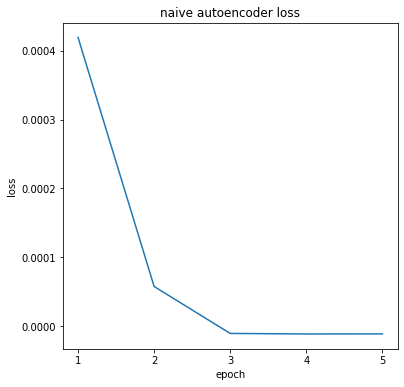

In [ ]:
plt.figure(figsize=(6,6))
plt.title('naive autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

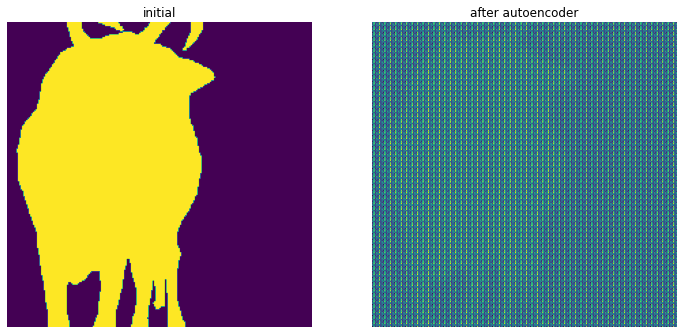

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
#index = np.random.randint(len(val_loader.dataset))
index = 12972
img = val_loader.dataset[index]
plt.title('initial')
plt.axis('off')
plt.imshow(img.squeeze().numpy());

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = naive_autoencoder(img.unsqueeze(0))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach().numpy().squeeze());

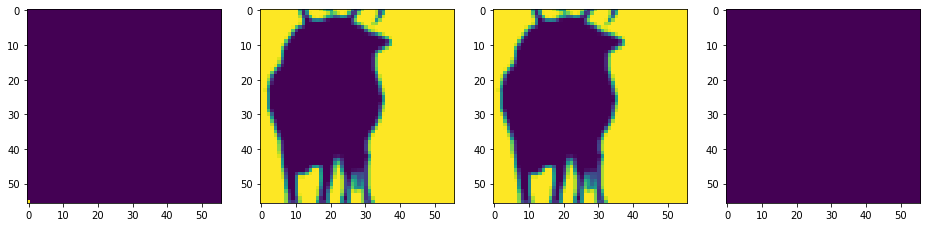

In [ ]:
hid = naive_autoencoder.encoder(img.unsqueeze(0))

fig = plt.figure(figsize=(16,4))
fig.add_subplot(1, 4, 1)
plt.imshow(hid[:,0,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 2)
plt.imshow(hid[:,1,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 3)
plt.imshow(hid[:,2,:,:].detach().cpu().squeeze().numpy());

fig.add_subplot(1, 4, 4)
plt.imshow(hid[:,3,:,:].detach().cpu().squeeze().numpy());

###Bigger one

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from models import Autoencoder

In [ ]:
model = Autoencoder().to(device)
summary(model, (1, 256, 256))

RuntimeError: ignored

In [ ]:
model = Autoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=2, gamma=5)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-37



  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [1/5], loss:-1.8229




100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [2/5], loss:-1.6108




100%|██████████| 200/200 [00:52<00:00,  3.78it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [3/5], loss:-1.7401




100%|██████████| 200/200 [00:52<00:00,  3.80it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

epoch [4/5], loss:-1.4881




100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


epoch [5/5], loss:-1.6219



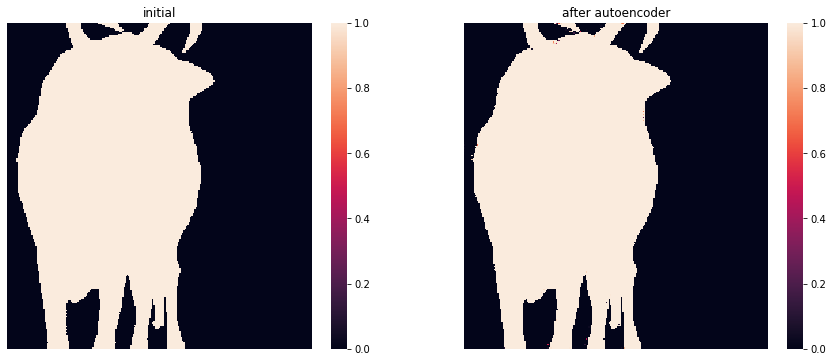

In [ ]:
neptune.create_experiment(name='conv1')
conv_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(conv_autoencoder, val_loader, neptune=neptune)
neptune.stop()

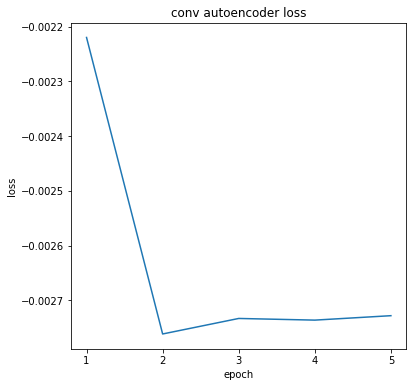

In [ ]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(conv_autoencoder.state_dict(), "conv_autoencoder.pth")

In [ ]:
autoencoder1 = Autoencoder().to(device)
autoencoder1.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder1.eval()

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec20): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec21): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec22): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm): Sigmoid()
)

###Layer norm

In [ ]:
from models import AutoencoderLN

In [ ]:
model = AutoencoderLN().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
         LeakyReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 32, 128, 112]          18,464
         LeakyReLU-4         [-1, 32, 128, 112]               0
            Conv2d-5            [-1, 8, 64, 56]           2,312
         LeakyReLU-6            [-1, 8, 64, 56]               0
            Conv2d-7            [-1, 1, 32, 28]              73
         LeakyReLU-8            [-1, 1, 32, 28]               0
   ConvTranspose2d-9            [-1, 8, 32, 28]              80
        LeakyReLU-10            [-1, 8, 32, 28]               0
  ConvTranspose2d-11           [-1, 32, 64, 56]           2,336
        LeakyReLU-12           [-1, 32, 64, 56]               0
  ConvTranspose2d-13         [-1, 64, 128, 112]          18,496
        LeakyReLU-14         [-1, 64, 1

In [ ]:
model = AutoencoderLN().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=3, gamma=3)
num_epochs = 3

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-40





  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



  0%|          | 1/200 [00:00<02:29,  1.33it/s]


  1%|          | 2/200 [00:01<02:07,  1.56it/s]


  2%|▏         | 3/200 [00:01<01:51,  1.77it/s]


  2%|▏         | 4/200 [00:01<01:42,  1.92it/s]


  2%|▎         | 5/200 [00:02<01:37,  1.99it/s]


  3%|▎         | 6/200 [00:02<01:36,  2.00it/s]


  4%|▎         | 7/200 [00:03<01:34,  2.05it/s]


  4%|▍         | 8/200 [00:03<01:30,  2.13it/s]


  4%|▍         | 9/200 [00:04<01:25,  2.25it/s]


  5%|▌         | 10/200 [00:04<01:27,  2.17it/s]


  6%|▌         | 11/200 [00:05<01:22,  2.28it/s]


  6%|▌         | 12/200 [00:05<01:23,  2.25it/s]


  6%|▋         | 13/200 [00:06<01:26,  2.17it/s]


  7%|▋         | 14/200 [00:06<01:30,  2.06it/s]


  8%|▊         | 15/200 [00:06<01:24,  2.18it/s]

epoch [1/3], loss:-2.4697






  0%|          | 1/200 [00:00<01:37,  2.03it/s]


  1%|          | 2/200 [00:00<01:37,  2.03it/s]


  2%|▏         | 3/200 [00:01<01:32,  2.12it/s]


  2%|▏         | 4/200 [00:01<01:32,  2.13it/s]


  2%|▎         | 5/200 [00:02<01:31,  2.13it/s]


  3%|▎         | 6/200 [00:02<01:32,  2.09it/s]


  4%|▎         | 7/200 [00:03<01:32,  2.09it/s]


  4%|▍         | 8/200 [00:03<01:28,  2.16it/s]


  4%|▍         | 9/200 [00:04<01:26,  2.22it/s]


  5%|▌         | 10/200 [00:04<01:22,  2.31it/s]


  6%|▌         | 11/200 [00:05<01:23,  2.26it/s]


  6%|▌         | 12/200 [00:05<01:26,  2.18it/s]


  6%|▋         | 13/200 [00:06<01:30,  2.08it/s]


  7%|▋         | 14/200 [00:06<01:24,  2.20it/s]


  8%|▊         | 15/200 [00:06<01:24,  2.19it/s]


  8%|▊         | 16/200 [00:07<01:24,  2.18it/s]


  8%|▊         | 17/200 [00:07<01:24,  2.17it/s]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]


 10%|▉         | 19/200 [00:08<01:27,  2.08it/s]


 10%|█         | 20/200 [00:09<01:27,

epoch [2/3], loss:-2.4273






  0%|          | 1/200 [00:00<01:38,  2.02it/s]


  1%|          | 2/200 [00:00<01:36,  2.06it/s]


  2%|▏         | 3/200 [00:01<01:34,  2.08it/s]


  2%|▏         | 4/200 [00:01<01:30,  2.17it/s]


  2%|▎         | 5/200 [00:02<01:31,  2.12it/s]


  3%|▎         | 6/200 [00:02<01:26,  2.24it/s]


  4%|▎         | 7/200 [00:03<01:31,  2.12it/s]


  4%|▍         | 8/200 [00:03<01:26,  2.23it/s]


  4%|▍         | 9/200 [00:04<01:30,  2.11it/s]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]


  6%|▌         | 11/200 [00:05<01:25,  2.21it/s]


  6%|▌         | 12/200 [00:05<01:23,  2.26it/s]


  6%|▋         | 13/200 [00:05<01:25,  2.18it/s]


  7%|▋         | 14/200 [00:06<01:25,  2.18it/s]


  8%|▊         | 15/200 [00:06<01:27,  2.12it/s]


  8%|▊         | 16/200 [00:07<01:26,  2.13it/s]


  8%|▊         | 17/200 [00:07<01:27,  2.10it/s]


  9%|▉         | 18/200 [00:08<01:23,  2.18it/s]


 10%|▉         | 19/200 [00:08<01:24,  2.13it/s]


 10%|█         | 20/200 [00:09<01:25,

epoch [3/3], loss:-1.7967



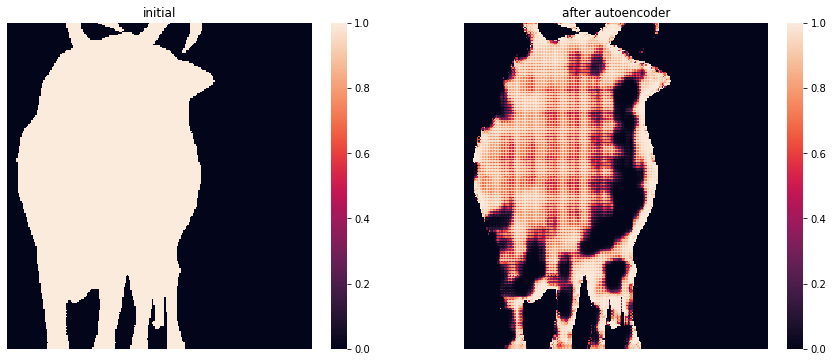

In [ ]:
neptune.create_experiment(name='ln1')
ln_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(ln_autoencoder, val_loader, neptune=neptune)
neptune.stop()

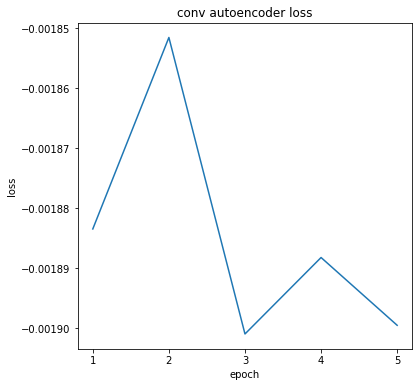

In [ ]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(ln_autoencoder.state_dict(), "ln_autoencoder.pth")

### Fixed size of hidden representation

In [ ]:
model = FixedAutoencoder().to(device)
summary(model, (1, 256, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 224]             640
              ReLU-2         [-1, 64, 256, 224]               0
            Conv2d-3         [-1, 64, 128, 112]          36,928
              ReLU-4         [-1, 64, 128, 112]               0
            Conv2d-5           [-1, 32, 64, 56]          18,464
              ReLU-6           [-1, 32, 64, 56]               0
            Conv2d-7           [-1, 16, 32, 28]           4,624
              ReLU-8           [-1, 16, 32, 28]               0
 AdaptiveMaxPool2d-9  [[-1, 16, 1, 1], [-1, 16, 1, 1]]               0
  ConvTranspose2d-10           [-1, 16, 64, 56]           2,320
             ReLU-11           [-1, 16, 64, 56]               0
  ConvTranspose2d-12           [-1, 32, 64, 56]           4,640
             ReLU-13           [-1, 32, 64, 56]               0
  ConvTranspose2d-14           [

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = Loss(alpha=3, gamma=3)
num_epochs = 5

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-42


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/200 [00:00<00:33,  5.86it/s]

epoch [1/5], loss:-2.6249



  0%|          | 1/200 [00:00<00:31,  6.32it/s]

epoch [2/5], loss:-2.2500



  0%|          | 1/200 [00:00<00:29,  6.83it/s]

epoch [3/5], loss:-2.6250



  0%|          | 1/200 [00:00<00:30,  6.43it/s]

epoch [4/5], loss:-2.6249



100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


epoch [5/5], loss:-2.4375



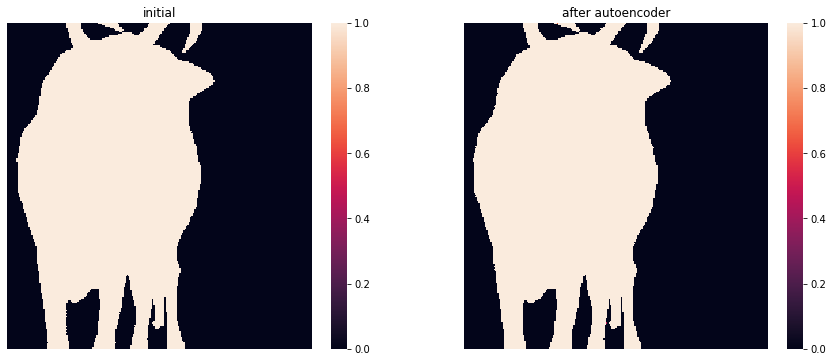

In [ ]:
neptune.create_experiment(name='fixed')
fix_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, train_loader, num_epochs, epoch_len=200, neptune=neptune)

test_model(fix_autoencoder, val_loader, neptune=neptune)
neptune.stop()

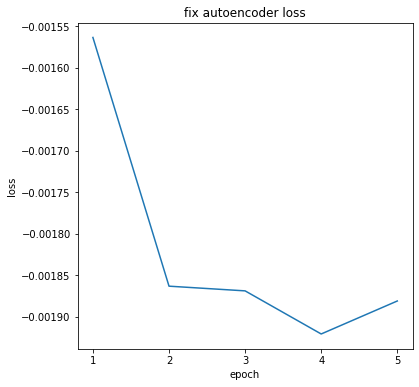

In [ ]:
plt.figure(figsize=(6,6))
plt.title('fix autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
torch.save(fix_autoencoder.state_dict(), "fix_autoencoder.pth")

### VAE-GAN

In [11]:
class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [12]:
class Encoder(nn.Module):
    def __init__(self, hid_size=32):
        super(Encoder, self).__init__()

        self.hid_size = hid_size
        self.mu = nn.Linear(self.hid_size*4, self.hid_size*4)
        self.log_sigma = nn.Linear(self.hid_size*4, self.hid_size*4)
        self.flatten = nn.Flatten()
        self.reshape = None

        self.encoder = nn.Sequential(*[
            nn.Conv2d(1, self.hid_size // 4, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size // 4, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size // 4, self.hid_size // 2, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size // 2, self.hid_size, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size, self.hid_size, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size, momentum=0.9),
            nn.ReLU(),
            nn.Flatten()
        ])

    def forward(self, x):

        x = self.encoder(x)
        mu_values = self.mu(x)
        log_sigma_values = self.log_sigma(x)
        return mu_values, log_sigma_values



class Decoder(nn.Module):
    def __init__(self, hid_size=32):
        super(Decoder, self).__init__()

        self.hid_size = hid_size
        self.decoder = nn.Sequential(*[
            RestoreShape([self.hid_size, 2, 2]),
            nn.ConvTranspose2d(self.hid_size, self.hid_size, kernel_size=5, stride=3, padding=0),
            nn.BatchNorm2d(self.hid_size, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size, self.hid_size // 2, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size // 2, self.hid_size // 2, kernel_size=5, stride=3, padding=0),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size // 2, self.hid_size // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size // 2, self.hid_size // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size // 2, self.hid_size // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.hid_size // 4, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(self.hid_size // 4, 1, kernel_size=5, stride=3, padding=0),
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        return self.decoder(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, hid_size=32):
        super(Discriminator, self).__init__()

        self.hid_size = hid_size
        self.model = nn.Sequential(
            nn.Conv2d(1, self.hid_size // 4, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size // 4, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size // 4, self.hid_size // 2, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size // 2, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size // 2, self.hid_size, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(self.hid_size, self.hid_size, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(self.hid_size, momentum=0.9),
            #nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(self.hid_size * 4, self.hid_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.hid_size, 1),
            nn.Sigmoid()
        )
    
    def features(self, img):
        return self.model(img)

    def forward(self, img):
        #img_flat = img.view(img.size(0), -1)
        validity = self.fc(self.model(img))

        return validity

In [14]:
class VAE_GAN(nn.Module):
  def __init__(self, hid_size=32):
        super(VAE_GAN, self).__init__()

        self.hid_size = hid_size
        self.reshape = RestoreShape([self.hid_size, 2, 2])

        self.encoder = Encoder(hid_size)
        self.decoder = Decoder(hid_size)
        self.discriminator = Discriminator(hid_size)
        

  def reparametrize(self, mu_values, log_sigma_values):
        std = torch.exp(0.5*log_sigma_values)
        sample = torch.randn_like(mu_values)
        latent_sample = mu_values + std * sample
        return latent_sample
    

  def forward(self, x):

        mu_values, log_sigma_values = self.encoder(x)
        x = self.reparametrize(mu_values, log_sigma_values)
        x = self.decoder(x)
        return x
        #return self.decoder(mu_values)

In [15]:
model = VAE_GAN(64).to(torch.device('cuda'))
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 74, 74]             416
       BatchNorm2d-2           [-1, 16, 74, 74]              32
              ReLU-3           [-1, 16, 74, 74]               0
            Conv2d-4           [-1, 32, 24, 24]          12,832
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
            Conv2d-7             [-1, 64, 8, 8]          51,264
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 2, 2]         102,464
      BatchNorm2d-11             [-1, 64, 2, 2]             128
             ReLU-12             [-1, 64, 2, 2]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                  [

In [28]:
model = Discriminator(64).to(torch.device('cuda'))
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 74, 74]             416
       BatchNorm2d-2           [-1, 16, 74, 74]              32
              ReLU-3           [-1, 16, 74, 74]               0
            Conv2d-4           [-1, 32, 24, 24]          12,832
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
            Conv2d-7             [-1, 64, 8, 8]          51,264
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 2, 2]         102,464
      BatchNorm2d-11             [-1, 64, 2, 2]             128
          Flatten-12                  [-1, 256]               0
           Linear-13                   [-1, 64]          16,448
        LeakyReLU-14                   

In [21]:
def train_batch(inputs,
                model,
                g_criterion, d_criterion, 
                opt_encoder, opt_decoder, opt_discriminator,
                diff_size=False,
                hid_size=32):
        model.train(True)

        mu, logvar = model.encoder(inputs)
        z_rand = Variable(torch.randn(len(inputs), hid_size*4).to(device), requires_grad=True).to(device)

        #train discriminator
        outputs = model(inputs)
        
        outputs_rand = model.decoder(z_rand)

        valid = Variable(torch.Tensor(inputs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(inputs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
            
        fake_loss = d_criterion(model.discriminator(outputs), fake)
        fake_loss += d_criterion(model.discriminator(outputs_rand), fake)
        real_loss = d_criterion(model.discriminator(inputs), valid)
        loss_discriminator = real_loss + fake_loss / 2
        
        #train decoder
        
        #outputs = model(inputs)
        #outputs_rand = model.decoder(z_rand)

        similarity = model.discriminator.features(inputs)
        similarity_rec = model.discriminator.features(outputs)
        rec_loss = ((similarity - similarity_rec)**2)

        loss_decoder = 10*rec_loss.mean() - 0.1*loss_discriminator
        #loss_decoder = 10*g_criterion(outputs, inputs) - 0.1*loss_discriminator
        
        #train encoder

        kl = -0.5 * torch.sum(-logvar.exp() - torch.pow(mu,2) + logvar + 1, 1)
        #loss_encoder = torch.mean(kl) + 10*g_criterion(outputs, inputs)
        loss_encoder = kl.mean() + 10*rec_loss.mean()

        opt_encoder.zero_grad()
        loss_encoder.backward(retain_graph=True)
        
        opt_decoder.zero_grad()
        loss_decoder.backward(retain_graph=True)
        
        opt_discriminator.zero_grad()
        loss_discriminator.backward(retain_graph=True)
        
        opt_encoder.step()
        opt_decoder.step()
        opt_discriminator.step()

        

        return model, loss_encoder.item(), loss_decoder.item(), loss_discriminator.item()

In [22]:
def train_vae_gan(model,
                  g_criterion, d_criterion, 
                  opt_encoder, opt_decoder, opt_discriminator,
                  dataloader, num_epochs, epoch_len=100, hid_size=32, batch_size=16, neptune=None, diff_size=False):
  
  #best_model_wts = deepcopy(generator.state_dict())
  best_loss = 10000.
  loss_history = []
  model.train()
  for epoch in range(num_epochs):
    loss_enc_epoch = 0
    loss_dec_epoch = 0
    loss_dis_epoch = 0
    for i in tqdm.trange(epoch_len):
        
        inputs = next(iter(dataloader))
        model, loss_encoder, loss_decoder, loss_discriminator = train_batch(inputs.to(device),
                                                                            model,
                                                                            g_criterion, d_criterion, 
                                                                            opt_encoder, opt_decoder, opt_discriminator,
                                                                            hid_size=hid_size)

        loss_enc_epoch += loss_encoder
        loss_dec_epoch += loss_decoder
        loss_dis_epoch += loss_discriminator
        if neptune is not None:
          neptune.log_metric('loss_encoder', loss_encoder)
          neptune.log_metric('loss_decoder', loss_decoder)
          neptune.log_metric('loss_discriminator', loss_discriminator)
    loss_enc_epoch /= epoch_len
    loss_dec_epoch /= epoch_len
    loss_dis_epoch /= epoch_len
    if neptune is not None:
        neptune.log_metric('epoch_loss_encoder', loss_enc_epoch)
        neptune.log_metric('epoch_loss_encoder', loss_dec_epoch)
        neptune.log_metric('epoch_loss_discriminator', loss_dis_epoch)
    #if g_loss < best_loss:
    #    best_model_wts = deepcopy(generator.state_dict())
    print('\n epoch [{}/{}], gen loss:{:.4f}, discr loss:{:.4f}\n'.format(epoch+1, num_epochs, loss_enc_epoch, loss_dis_epoch))

  return model

In [23]:
model = VAE_GAN(64).to(device)
#vae_layers = set((*model.encoder.parameters(), *model.decoder.parameters()))
opt_encoder = optim.Adam(model.encoder.parameters(), lr=1e-3)
opt_decoder = optim.Adam(model.decoder.parameters(), lr=1e-3)
opt_discriminator = optim.Adam(model.discriminator.parameters(), lr=1e-6)
d_criterion = nn.BCELoss().to(device)
g_criterion = Loss(alpha=10, gamma=3).to(device)
#g_criterion = nn.MSELoss()
num_epochs = 10


https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-136


  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [1/10], gen loss:15.8449, discr loss:1.3325



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [2/10], gen loss:13.9232, discr loss:1.2725



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [3/10], gen loss:14.0645, discr loss:1.2357



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [4/10], gen loss:14.0880, discr loss:1.1988



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [5/10], gen loss:14.0364, discr loss:1.1789



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [6/10], gen loss:14.0371, discr loss:1.1554



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [7/10], gen loss:14.1257, discr loss:1.1398



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [8/10], gen loss:14.3388, discr loss:1.1107



  0%|          | 0/300 [00:00<?, ?it/s]


 epoch [9/10], gen loss:14.5884, discr loss:1.0867



100%|██████████| 300/300 [01:32<00:00,  3.26it/s]



 epoch [10/10], gen loss:14.4871, discr loss:1.0592



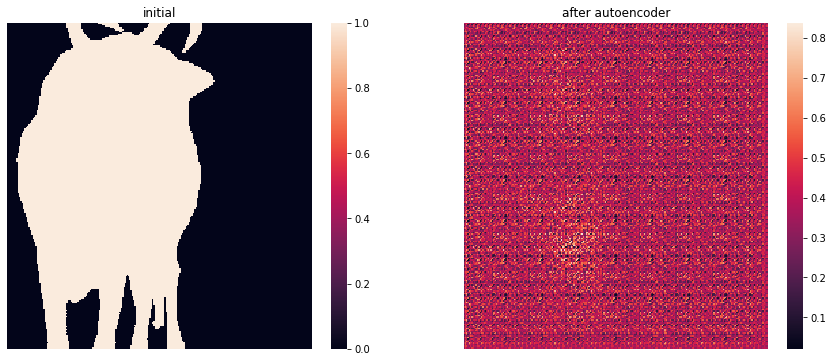

In [24]:
neptune.create_experiment(name='vae-gan rec loss')
vae = train_vae_gan(model, 
                    g_criterion, d_criterion,
                    opt_encoder, opt_decoder, opt_discriminator,
                    train_loader, num_epochs, epoch_len=300, neptune=neptune, hid_size=64)

test_model(vae, train_loader, val_loader, neptune=neptune)
neptune.stop()

In [17]:
model = VAE_GAN(128).to(device)
vae_layers = set((*model.encoder.parameters(), *model.decoder.parameters()))
opt= optim.Adam(vae_layers, lr=1e-3)

criterion = Loss(alpha=10, gamma=3).to(device)
#criterion = nn.MSELoss().to(device)
num_epochs = 10

In [18]:
neptune.create_experiment(name='vae')
vae, loss_history_ae = train_autoencoder(model, 
                                         criterion,
                                         opt, 
                                         train_loader, num_epochs, epoch_len=300, neptune=neptune)

test_model(vae, train_loader, val_loader, neptune=neptune)
neptune.stop()

https://ui.neptune.ai/a.chubcheva/Instance-segmentation/e/IN-129


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/300 [00:00<00:44,  6.74it/s]

epoch [1/10], loss:-5.3265



  0%|          | 1/300 [00:00<00:39,  7.53it/s]

epoch [2/10], loss:-3.8330



  0%|          | 1/300 [00:00<00:41,  7.20it/s]

epoch [3/10], loss:-4.1334



  0%|          | 1/300 [00:00<00:40,  7.35it/s]

epoch [4/10], loss:-4.2313



  0%|          | 1/300 [00:00<00:39,  7.55it/s]

epoch [5/10], loss:-4.7601



  0%|          | 1/300 [00:00<00:40,  7.31it/s]

epoch [6/10], loss:-3.5643



  0%|          | 1/300 [00:00<00:38,  7.69it/s]

epoch [7/10], loss:-3.6151



  0%|          | 1/300 [00:00<00:38,  7.72it/s]

epoch [8/10], loss:-5.1070



  0%|          | 1/300 [00:00<00:39,  7.53it/s]

epoch [9/10], loss:-3.9787



100%|██████████| 300/300 [00:40<00:00,  7.42it/s]

epoch [10/10], loss:-2.8747



TypeError: ignored

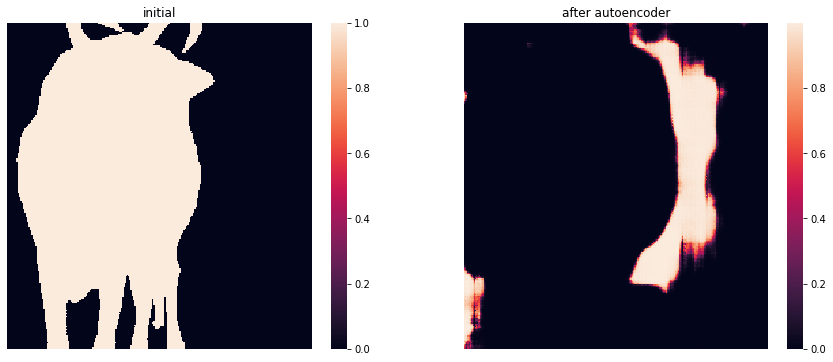

In [20]:
test_model(vae, train_loader, val_loader, neptune=neptune)
neptune.stop()